In [195]:
# URL Download
import csv
import io
import urllib.request
import requests

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read in data from the Berlin Polizei URL
def load_data():
    url = "https://www.internetwache-polizei-berlin.de/vdb/Fahrraddiebstahl.csv"
    download = requests.get(url)
    decoded_content = download.content.decode('ISO-8859-1')
    file = decoded_content.splitlines()

    cr = csv.DictReader(file, delimiter=',')
    my_list = list(cr)
    df  = pd.DataFrame(my_list)
    return df

In [3]:
###################################
###  Clean data ######

#dict to translate from German to English
eng_col_names = {
    "ANGELEGT_AM": "date_reported",
    "TATZEIT_ANFANG_DATUM": "date_theft_start",
    "TATZEIT_ANFANG_STUNDE": "hour_theft_start",
    "TATZEIT_ENDE_DATUM": "date_theft_end",
    "TATZEIT_ENDE_STUNDE": "hour_theft_end",
    "LOR": "LOR",
    "SCHADENSHOEHE": "estimated_value",
    "VERSUCH": "attempt",
    "ART_DES_FAHRRADS": "type_bike", 
    "DELIKT": "theft_type",
    "ERFASSUNGSGRUND": "theft_type_detail"    
}

# define function for renaming the categories
def rename_type_bike(x): 
    if x == "Herrenfahrrad": 
        return "man's bike"
    if x == "Damenfahrrad":
        return "woman's bike"
    if x == "Fahrrad":
        return "bike"
    if x == "Kinderfahrrad":
        return "child's bike"
    else: 
        return "other bike"

# dictionary for "attempt"
attempt_dict = {
    "Ja": "Yes", 
    "Nein": "No", 
    "Unbekannt": "Unknown"
}

In [4]:
# Concatenates translation of column and category names, 
#  conversion of dtypes, drop duplicates and create 
#  higher regional levels from LOR
def clean_theft_data(d):
    """returns a clean dataframe"""
    #translate columns to English
    d.rename(columns= eng_col_names, inplace=True)
    
    #translate bike type to English
    d["type_bike"] = d["type_bike"].apply(rename_type_bike)
    
    #translate attempt type to English
    d["attempt"] = d["attempt"].map(attempt_dict)
    
    # convert the date columns to format='%d.%m.%Y
    d["date_reported"] = pd.to_datetime(d["date_reported"], format='%d.%m.%Y')
    d["date_theft_start"] = pd.to_datetime(d["date_theft_start"], format='%d.%m.%Y')
    d["date_theft_end"] = pd.to_datetime(d["date_theft_end"], format='%d.%m.%Y')
    
    # convert the time columns to int
    d["hour_theft_start"] = d["hour_theft_start"].astype(int)
    d["hour_theft_end"] = d["hour_theft_end"].astype(int)
    
    #convert value column to float
    d["estimated_value"] = d["estimated_value"].astype(float)
    
    #drop duplicates
    d = d.drop_duplicates()
    
    # BZR (first six numbers)
    d["BZR"] = d["LOR"].str[:6]
    
    # PGR (first four numbers)
    d["PGR"] = d["LOR"].str[:4]
    
    # Bezirk (first four numbers)
    d["Bezirk"] = d["LOR"].str[:2]
    
    return d

In [14]:
# Group by bezirk and date reported sum up
def pivot_theft_data(d):
    d = d.pivot_table(index = "date_reported", columns = "Bezirk", values = "type_bike", aggfunc= "count")
    d.fillna(value = 0, inplace=True)
    return d

In [6]:
# Calculate percentage theft by Bezirk
def perc_split_bezirk(d):
    """returns df showing % split of bikes stolen over the last 2 weeks per Bezirk in Berlin"""
    d = d[-15:]
    d.loc['perc_split']= d.sum()
    d = d.div(d.sum(axis=1), axis=0)
    d = d.iloc[-1]
    return pd.DataFrame(d)

In [17]:
def calculate_rolling_average(df, window_size):
    fill_value = df["total"][-window_size:].mean()
    df["total_moving_average"] = df["total"].rolling(window = window_size, center = False).mean().fillna(fill_value)

In [18]:
# Create the dataframe for the modelling
def create_modelling_dataframe():
    df = load_data()
    df = clean_theft_data(df)
    df = pivot_theft_data(df)

    # add "total column"
    df["total"] = df.sum(axis = 1)

    # calculate rolling average
    calculate_rolling_average(df, window_size = 3)
    
    # select relevant columns for modelling
    cols_list =  ["total", "total_moving_average"]
    df = df[cols_list]
    
    return df

In [9]:
def bikes_stolen_365():
    """returns total bikes reported as stolen in the last 365 days in Berlin"""
    df = load_data()
    df = clean_theft_data(df)
    df = pivot_theft_data(df)
    df['Total'] = df.sum(axis=1)
    df = pd.DataFrame(df["Total"])
    df =df[-365:]
    total_stolen_365=df.sum().values[0]
    return int(total_stolen_365)

In [10]:
def theft_frequency():
    """returns frequency (in minutes) of bikes being reported as stolen in Berlin in the last 365 days"""
    minutes_day=1440
    minutes_year=1440*365
    return round(minutes_year/bikes_stolen_365())

In [19]:
test = create_modelling_dataframe()

/tmp/ipykernel_7448/2814565939.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["BZR"] = d["LOR"].str[:6]
/tmp/ipykernel_7448/2814565939.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["PGR"] = d["LOR"].str[:4]
/tmp/ipykernel_7448/2814565939.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [21]:
test.tail()

Bezirk,total,total_moving_average
date_reported,,
2022-03-03,50.0,45.000000
2022-03-04,37.0,42.333333
2022-03-05,34.0,40.333333
2022-03-06,21.0,30.666667
2022-03-07,42.0,32.333333


In [265]:
bikes_stolen_365()

20269

In [268]:
theft_frequency()

26

In [32]:
def get_X_y(dataset, window_size= 31, future_horizon =1):

  X = []
  y = []

  for i in range(0, dataset.shape[0] - window_size - future_horizon):
    X.append(dataset[i: i + window_size])
    y.append(dataset["total"][i + window_size: i + window_size + future_horizon])

  return np.array(X), np.array(y)

In [22]:
import numpy as np
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import Sequential, callbacks

def create_opt_model(): 
    """
    Creates the finetuned model selected in B_Theft_Modelling
    Outputs models, that needs to be compiled and fit"""
    model = Sequential()
    # first LSTM layer
    model.add(LSTM(units = 70, activation = "tanh", return_sequences = True))
    model.add(Dropout(0.2))
    # second LSTM layer
    model.add(LSTM(units= 30, activation= "tanh", return_sequences= False))
    model.add(Dropout(0.2))

    # output layer to predict one value
    model.add(Dense(1, activation= "linear"))
    return model

2022-03-09 10:50:48.305737: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-09 10:50:48.305772: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
window_size = 31
future_horizon = 1

X_train, y_train = get_X_y(window_size,future_horizon, df_train)
X_test, y_test = get_X_y(window_size, future_horizon, df_test)

X_test = np.expand_dims(X_test, 2)
X_train = np.expand_dims(X_train, 2)

In [24]:
model = create_opt_model()

2022-03-09 10:50:56.336654: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-09 10:50:56.336713: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-09 10:50:56.336729: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-C0GM00LC): /proc/driver/nvidia/version does not exist
2022-03-09 10:50:56.336937: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
model

In [135]:
X, y = get_X_y(df)

In [137]:
es = callbacks.EarlyStopping(patience = 5, restore_best_weights=True)

In [136]:
X.shape, y.shape

((395, 31, 2), (395, 1, 2))

In [ ]:
model.fit()

In [11]:
df = create_modelling_dataframe()

/tmp/ipykernel_7448/2814565939.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["BZR"] = d["LOR"].str[:6]
/tmp/ipykernel_7448/2814565939.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["PGR"] = d["LOR"].str[:4]
/tmp/ipykernel_7448/2814565939.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [13]:
df.tail()

Bezirk,total,total_moving_average
date_theft_start,,
2022-02-28,30.0,32.333333
2022-03-01,40.0,36.000000
2022-03-02,38.0,37.000000
2022-03-03,33.0,35.666667
2022-03-04,36.0,35.666667


In [33]:
X, y = get_X_y(df, window_size=31, future_horizon=1)

In [34]:
X.shape

(396, 31, 2)

In [35]:
y.shape

(396, 1)

In [ ]:
def get_pred_array():
    # read in dataset from URL
    df = load_data()
    # clean dataset
    clean_theft_data(df)
    # group by Bezirk and date reported
    pivot_theft_data(df)
    # add "total column"
    df["total"] = df.sum(axis = 1)
    # calculate rolling average
    calculate_rolling_average(df, window_size = 3)
    # drop not-needed columns
    cols_list =  ["total", "total_moving_average"]
    df = df[cols_list]
    # only keep last 31 days

In [236]:
# read in dataset from URL
df = create_modelling_dataframe()
#only keep the last 31 days
df = df[-31:]
# create input array
X_input = np.expand_dims(df, axis = 0)

In [54]:
model.predict(X_input)[0][0]

-0.0467952

In [44]:
df.shape

(31, 2)

In [46]:
df.shape

(31, 2)

In [60]:
import datetime

In [66]:
date = df.index[-1] 
pred_date =  df.index[-1] +  datetime.timedelta(days = 1) 
print(pred_date.date())

2022-03-08


In [59]:
df.index[-1] 

Timestamp('2022-03-07 00:00:00')

In [49]:
np.expand_dims(df, axis = 0).shape

(1, 31, 2)

In [69]:
d = {"date": [pred_date.date()], "total": [13]}

In [80]:
pd.DataFrame(d, index=[0]).set_index("date")

,total
date,
2022-03-08,13


In [78]:
df

Bezirk,total,total_moving_average
date_reported,,
2022-02-05,37.0,37.000000
2022-02-06,36.0,35.666667
2022-02-07,46.0,39.666667
2022-02-08,51.0,44.333333
2022-02-09,53.0,50.000000
2022-02-10,67.0,57.000000
2022-02-11,54.0,58.000000
2022-02-12,41.0,54.000000
2022-02-13,50.0,48.333333


In [110]:
import joblib
import datetime

In [105]:
# load model from joblib file
def load_joblib_model():
    """Read in the fitted model from the locally saved joblib.file
    """
    model = joblib.load("model.joblib")
    return model


# read in X_array for prediction
def get_pred_array():
    """"Create the input array X to predict for the next day
    """
    # read in newest dataset from the URL
    df = create_modelling_dataframe()
    # only keep last 31 days
    df = df[-31:]
    #create input array
    X_input = np.expand_dims(df, axis = 0)
    pred_date =  df.index[-1] +  datetime.timedelta(days = 1)

    return X_input, pred_date.date()

def predict_next_day():
    """Given an input array X of shape (1, 31, 2) predict a total value
    for the next day.
    Output: Predicted value and date the prediction refers to"""
    X_input, pred_date = get_pred_array()

    # load model and predict
    model = load_joblib_model()
    y_pred = model.predict(X_input)
    d = {"date_reported": pred_date,
         "total": round(y_pred[0][0], 0)}
    return pd.DataFrame(d, index = [0])

In [97]:
!pwd

/home/jakob/code/hmichinaka/berlin-bike-theft-forecasting/notebooks


In [234]:
import plotly.express as px

def pred_ts_chart():
    """Create dataframe necessary to show a time series chart (total of reported stolen
    bikes in the last 31 days plus prediction for day 32)"""
    # read in data for the last 31 days and date of prediction
    X_input, pred_date = get_pred_array()
    
    # we only need the "total" column of X_input
    X_input = X_input[0][:,0]
    X_input = pd.Series(X_input)
    
    # get the predicted value for day 32 and the corresponding date
    pred_df = predict_next_day()
    
    # create empty dataframe starting 31 days before prediction date to prediction date
    chart_df = pd.DataFrame({'date':pd.date_range(start = pred_df["date_reported"][0] - datetime.timedelta(days=31), end = pred_df["date_reported"][0])})
        
    # concatenate the values from X_input to the empty dataframe
    chart_df = pd.concat([chart_df, X_input], axis = 1)
    chart_df.rename(columns={0:"total"}, inplace=True)
    
    # add the predicted value as the last value 
    chart_df.iloc[-1, 1] = pred_df["total"][0]
    
    fig = px.line(chart_df, x="date", y="total", title= "Number of reported stolen bikes in Berlin in the last 31 days and prediction for the next day(red line)")
    fig.add_scattergl(x=chart_df["date"].where(chart_df["date"] >=chart_df.iloc[-2,0]), y=chart_df["total"], line={"color": "red"},
                  showlegend=False)

    fig.show()

In [237]:
pred_ts_chart()

## Map with percentage per Bezirk (last 14 days)

In [263]:
def prediction_by_Bezirk():
    """Allocates the predicted total for the next day on the 12 Bezirke 
    based on the mean percentage split for the last 14 days. 
    """
    # load data, clean it and group by Bezirke
    df = load_data()
    df= clean_theft_data(df)
    df = pivot_theft_data(df)
    
    # create dataframe with the mean percentage split of the last 14 days
    df= perc_split_bezirk(df)
    
    # call the prediction for the next day and assign it as a new column to the dataframe
    df["pred_total"] = predict_next_day().iloc[0,1]
    
    # create dataframe with just the split up values
    df  = pd.DataFrame(round(df["perc_split"] * df["pred_total"], 0)).rename(columns={0: "Prediction_total"})
    
    return df

In [264]:
prediction_by_Bezirk()

,Prediction_total
Bezirk,
01,5.0
02,7.0
03,8.0
04,4.0
05,1.0
06,2.0
07,4.0
08,4.0
09,3.0


In [ ]:
pd.

In [261]:
pred = predict_next_day().iloc[0,1]

In [262]:
pred

42.0

In [239]:
df = load_data()
df= clean_theft_data(df)
df = pivot_theft_data(df)

In [240]:
df

Bezirk,01,02,03,04,05,06,07,08,09,10,11,12
date_reported,,,,,,,,,,,,
2021-01-01,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2021-01-02,1.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2021-01-03,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2021-01-04,2.0,1.0,4.0,4.0,0.0,3.0,2.0,0.0,1.0,1.0,1.0,2.0
2021-01-05,6.0,4.0,5.0,7.0,0.0,0.0,5.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-04,5.0,13.0,5.0,2.0,0.0,3.0,3.0,2.0,2.0,1.0,0.0,1.0
2022-03-05,3.0,4.0,8.0,3.0,0.0,2.0,3.0,2.0,4.0,1.0,2.0,2.0
2022-03-06,2.0,2.0,2.0,4.0,0.0,1.0,4.0,3.0,1.0,0.0,1.0,1.0


In [242]:
type(perc_split_bezirk(df))

pandas.core.frame.DataFrame

In [243]:
df= perc_split_bezirk(df)

In [244]:
df

,perc_split
Bezirk,
01,0.122222
02,0.173016
03,0.182540
04,0.100000
05,0.020635
06,0.058730
07,0.100000
08,0.088889
09,0.069841


In [245]:
df["pred_total"] = 42 

In [256]:
pd.DataFrame(round(df["perc_split"] * df["pred_total"], 0)).rename(columns={0: "Prediction_total"})

,Prediction_total
Bezirk,
01,5.0
02,7.0
03,8.0
04,4.0
05,1.0
06,2.0
07,4.0
08,4.0
09,3.0


## Estimated value

In [311]:
df = load_data()

In [312]:
df.head()

,ANGELEGT_AM,TATZEIT_ANFANG_DATUM,TATZEIT_ANFANG_STUNDE,TATZEIT_ENDE_DATUM,TATZEIT_ENDE_STUNDE,LOR,SCHADENSHOEHE,VERSUCH,ART_DES_FAHRRADS,DELIKT,ERFASSUNGSGRUND
0,08.03.2022,07.03.2022,20,08.03.2022,10,06400735,400,Nein,Kinderfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
1,08.03.2022,07.03.2022,16,08.03.2022,15,04300620,679,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
2,08.03.2022,07.03.2022,16,08.03.2022,09,03601244,799,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
3,08.03.2022,07.03.2022,17,08.03.2022,11,07300516,1200,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
4,08.03.2022,08.03.2022,09,08.03.2022,11,09200715,649,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern


In [313]:
df= clean_theft_data(df)

In [314]:
df.head()

,date_reported,date_theft_start,hour_theft_start,date_theft_end,hour_theft_end,LOR,estimated_value,attempt,type_bike,theft_type,theft_type_detail,BZR,PGR,Bezirk
0,2022-03-08,2022-03-07,20,2022-03-08,10,06400735,400.0,No,child's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,064007,0640,06
1,2022-03-08,2022-03-07,16,2022-03-08,15,04300620,679.0,No,woman's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,043006,0430,04
2,2022-03-08,2022-03-07,16,2022-03-08,9,03601244,799.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,036012,0360,03
3,2022-03-08,2022-03-07,17,2022-03-08,11,07300516,1200.0,No,woman's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,073005,0730,07
4,2022-03-08,2022-03-08,9,2022-03-08,11,09200715,649.0,No,woman's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,092007,0920,09


In [324]:
type(start_date)

datetime.date

In [335]:
pd.to_datetime(df["date_reported"])

0       2022-03-08
1       2022-03-08
2       2022-03-08
3       2022-03-08
4       2022-03-08
           ...    
22243   2021-01-02
22244   2021-01-01
22245   2021-01-01
22246   2021-01-01
22247   2021-01-01
Name: date_reported, Length: 22212, dtype: datetime64[ns]

In [328]:
type(df["date_reported"].date())

AttributeError: 'Series' object has no attribute 'date'

In [323]:
np.logical_and(df["theft_type"] != "Keller- und Bodeneinbruch", df["date_reported"] >= start_date)

TypeError: Invalid comparison between dtype=datetime64[ns] and date

In [338]:
print(datetime.datetime.today())

2022-03-09 15:48:38.232948


In [ ]:
df["theft_type"] != "Keller- und Bodeneinbruch"

In [349]:
start_date = datetime.datetime.today() - datetime.timedelta(365)
#cond_1 = df["date_reported"] >= start_date
#cond_2 = df["theft_type"] != "Keller- und Bodeneinbruch"
cond = np.logical_and(df["theft_type"] != "Keller- und Bodeneinbruch", df["date_reported"] >= start_date)
df = df[cond]

In [286]:
round(df.estimated_value.mean())

892

In [287]:
df.describe()

,hour_theft_start,hour_theft_end,estimated_value
count,21234.000000,21234.000000,21234.000000
mean,14.500141,13.382971,892.317039
std,5.317182,5.260463,843.043051
min,0.000000,0.000000,0.000000
25%,10.000000,9.000000,400.000000
50%,16.000000,14.000000,649.000000
75%,19.000000,18.000000,1046.000000
max,23.000000,23.000000,9999.000000


In [289]:
df.estimated_value.mode()

0    500.0
Name: estimated_value, dtype: float64

In [290]:
import seaborn as sns

In [295]:
cond = df.estimated_value <= 2500

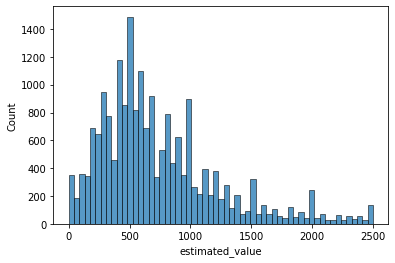

In [296]:
sns.histplot(df[cond].estimated_value);

In [298]:
df[cond].estimated_value.median()

600.0

In [299]:
def mean_estimated_value(): 
    df = load_data()
    df= clean_theft_data(df)
    cond = df["theft_type"] != "Keller- und Bodeneinbruch"
    df = df[cond]
    return f"The mean estimated value of a reported stolen bike is {round(df.estimated_value.mean())} Euro"

In [300]:
mean_estimated_value()

'The mean estimated value of a reported stolen bike is 892 Euro'

## Hourly count of stolen bikes

In [301]:
df = load_data()

In [304]:
df = clean_theft_data(df)

In [303]:
df.head()

,ANGELEGT_AM,TATZEIT_ANFANG_DATUM,TATZEIT_ANFANG_STUNDE,TATZEIT_ENDE_DATUM,TATZEIT_ENDE_STUNDE,LOR,SCHADENSHOEHE,VERSUCH,ART_DES_FAHRRADS,DELIKT,ERFASSUNGSGRUND
0,08.03.2022,07.03.2022,20,08.03.2022,10,06400735,400,Nein,Kinderfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
1,08.03.2022,07.03.2022,16,08.03.2022,15,04300620,679,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
2,08.03.2022,07.03.2022,16,08.03.2022,09,03601244,799,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
3,08.03.2022,07.03.2022,17,08.03.2022,11,07300516,1200,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
4,08.03.2022,08.03.2022,09,08.03.2022,11,09200715,649,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern


In [310]:
count_per_hour = df.groupby("hour_theft_start").count()
count_per_hour = count_per_hour[["date_reported"]].reset_index()
count_per_hour["count_stolen"] = count_per_hour["date_reported"] 
fig = px.line(count_per_hour, x='hour_theft_start', y='count_stolen', 
              title='Berlin: Hourly count of stolen bikes from 2021-01-01', 
             labels={"hour_theft_start": "Assumed hour of theft", "count_stolen": "Number of stolen bikes"})

fig.show()

## Memoization

In [ ]:
import memoized_property

In [ ]:
@Memoize
def factorial(k):
    if k < 2: return 1
    return k * factorial(k - 1)